In [1]:
# importeer libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels
import scipy
from scipy.stats import norm
import math
import numpy as np
import statsmodels.tsa.seasonal
import statsmodels.graphics.tsaplots
import matplotlib

In [2]:
df = pd.read_csv('helpdesk.csv')
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8115 entries, 0 to 8114
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_date      8115 non-null   datetime64[ns]
 1   priority        8115 non-null   object        
 2   experience_cat  8115 non-null   object        
 3   team_size       8115 non-null   int64         
 4   budget          8115 non-null   int64         
 5   type            8115 non-null   object        
 6   status          8115 non-null   object        
 7   end_date        6846 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 507.3+ KB


In [4]:
aantallen = df.groupby(['start_date']).size().reset_index(name='aantal')
aantallen[:20]

,start_date,aantal
0,2025-04-01,61
1,2025-04-02,37
2,2025-04-03,25
3,2025-04-04,12
4,2025-04-05,26
5,2025-04-06,8
6,2025-04-07,31
7,2025-04-08,43
8,2025-04-09,41
9,2025-04-10,32


In [5]:
df["dagen_nodig"] = (df["end_date"] - df["start_date"]).dt.days
resolved = df[df["end_date"].notna()]

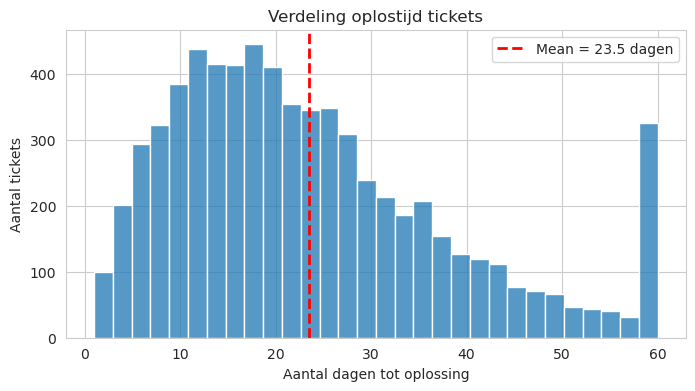

In [6]:
mean_days = resolved["dagen_nodig"].mean()

plt.figure(figsize=(8,4))
sns.histplot(
    data=resolved,
    x="dagen_nodig",
    bins=30
)

plt.axvline(
    mean_days,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean = {mean_days:.1f} dagen"
)

plt.xlabel("Aantal dagen tot oplossing")
plt.ylabel("Aantal tickets")
plt.title("Verdeling oplostijd tickets")
plt.legend(loc="upper right")
plt.show()


In [7]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = statsmodels.tsa.stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used",],)
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",
    nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


# voer ADF-test uit
adf_test(aantallen['aantal'])
kpss_test(aantallen['aantal'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.405110
p-value                          0.579824
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Results of KPSS Test:
Test Statistic           1.377948
p-value                  0.010000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipykernel_3300955/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


> Hij is nog niet stationair, dit gaan we hem maken


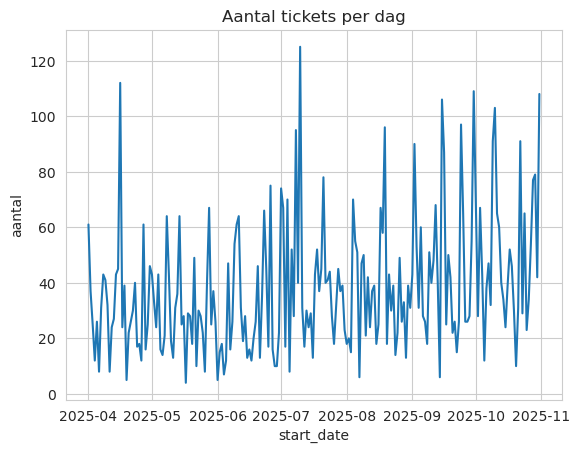

In [8]:
sns.lineplot(aantallen, x='start_date', y='aantal')
plt.title("Aantal tickets per dag")
plt.show()

In [9]:
aantallen['aantal_boxcox'], fitted_lambda = scipy.stats.boxcox(aantallen['aantal'])
fitted_lambda

0.24609811707668786

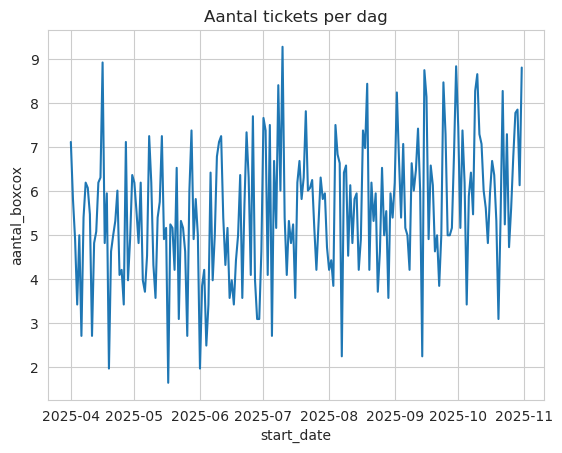

In [10]:
sns.lineplot(aantallen, x='start_date', y='aantal_boxcox')
plt.title("Aantal tickets per dag")
plt.show()

In [11]:
adf_test(aantallen['aantal_boxcox'])
kpss_test(aantallen['aantal_boxcox'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.325373
p-value                          0.617486
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Results of KPSS Test:
Test Statistic           1.503822
p-value                  0.010000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipykernel_3300955/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


In [12]:
aantallen['aantal_sqrt'] = np.sqrt(aantallen['aantal'])

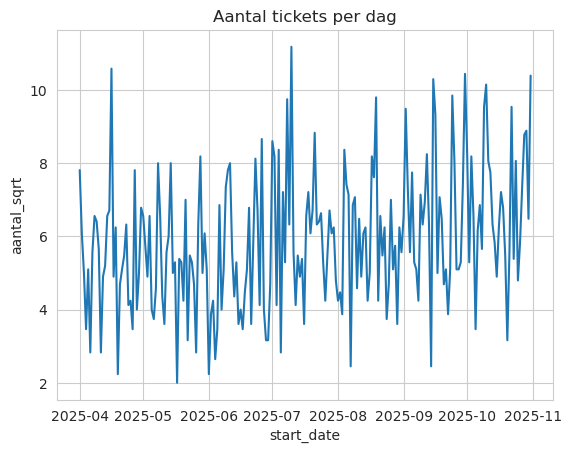

In [13]:
sns.lineplot(aantallen, x='start_date', y='aantal_sqrt')
plt.title("Aantal tickets per dag")
plt.show()

In [14]:
adf_test(aantallen['aantal_sqrt'])
kpss_test(aantallen['aantal_sqrt'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.328444
p-value                          0.616061
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Results of KPSS Test:
Test Statistic           1.475956
p-value                  0.010000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipykernel_3300955/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


In [15]:
aantallen['aantal_sqrt_boxcox'], fitted_lambda = scipy.stats.boxcox(aantallen['aantal_sqrt'])
fitted_lambda

0.4921962046367118

In [16]:
adf_test(aantallen['aantal_sqrt_boxcox'])
kpss_test(aantallen['aantal_sqrt_boxcox'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.325373
p-value                          0.617486
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Results of KPSS Test:
Test Statistic           1.503822
p-value                  0.010000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipykernel_3300955/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


In [17]:
aantallen['aantal_boxcox_detrend'] = aantallen['aantal_boxcox'] - \
                                                     aantallen['aantal_boxcox'].shift(1)

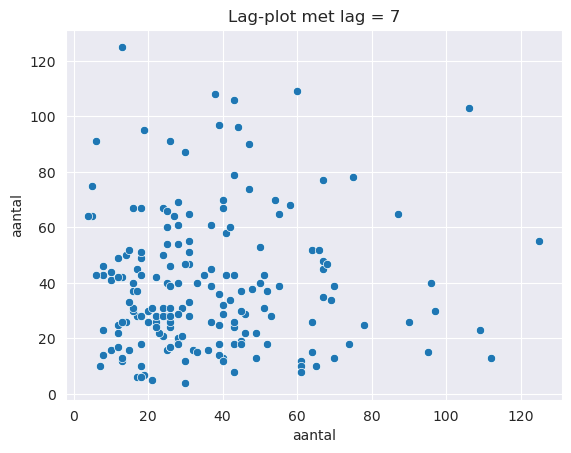

In [18]:
sns.set_style('darkgrid')
sns.scatterplot(aantallen,
x = aantallen.shift(25)['aantal'],
y = aantallen['aantal'])
plt.title("Lag-plot met lag = 7")
plt.ticklabel_format(axis='both', style='plain')
plt.show()
                          


In [19]:
# functie voor plotten van time series
def plot_series(df, series_name, lags=40, diff=0, seasonal_diff=0, seasonal_period=12):
    """
    Plot a time series alongside its ACF and PACF with Bartlett bounds.
    Includes options for regular and seasonal differencing.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing multiple time series as columns.
    series_name : str
        Column name of the series to plot.
    lags : int
        Number of lags for ACF/PACF.
    diff : int, default=0
        Number of regular differences to apply.
    seasonal_diff : int, default=0
        Number of seasonal differences to apply.
    seasonal_period : int, default=12
        Seasonal period (e.g., 12 for monthly data with yearly seasonality).
    """
    series = df[series_name]

    # Apply differencing
    for _ in range(diff):
        series = series.diff()
    for _ in range(seasonal_diff):
        series = series.diff(seasonal_period)
    series = series.dropna()
    
    print(adf_test(series))
    print(kpss_test(series))

    # Compute ACF/PACF (drop lag 0)
    acf_vals = acf(series, nlags=lags, fft=False)[1:]
    pacf_vals = pacf(series, nlags=lags, method="ywm")[1:]
    lags_range = np.arange(1, len(acf_vals)+1)

    # Bartlett bounds
    n = len(series)
    conf = 1.96 / np.sqrt(n)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Time series
    axes[0].plot(series.index, series.values, color="steelblue")
    axes[0].set_title(f"Series: {series_name} (diff={diff}, seas_diff={seasonal_diff})")

    # ACF
    axes[1].stem(lags_range, acf_vals, basefmt=" ")
    axes[1].hlines([conf, -conf], xmin=0, xmax=lags, colors="red", linestyles="dashed")
    axes[1].axhline(0, color="black", linewidth=0.8)
    axes[1].set_title("ACF-plot")

    # PACF
    axes[2].stem(lags_range, pacf_vals, basefmt=" ")
    axes[2].hlines([conf, -conf], xmin=0, xmax=lags, colors="red", linestyles="dashed")
    axes[2].axhline(0, color="black", linewidth=0.8)
    axes[2].set_title("PACF-plot")

    plt.tight_layout()
    plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -1.405110
p-value                          0.579824
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
None
Results of KPSS Test:
Test Statistic           1.377948
p-value                  0.010000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


/tmp/ipykernel_3300955/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


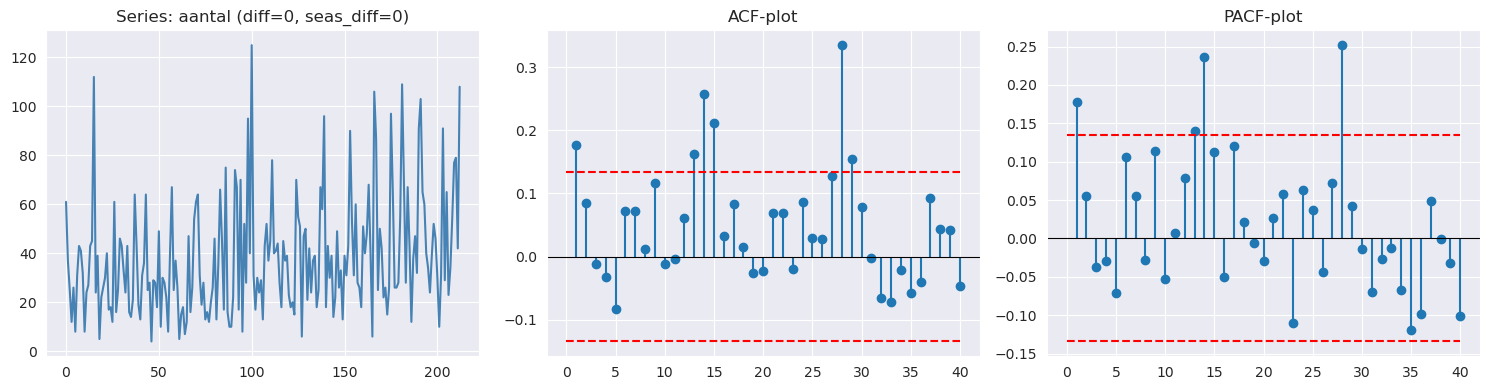

In [20]:
plot_series(aantallen, 'aantal', lags=40)

Results of Dickey-Fuller Test:
Test Statistic                  -5.608127
p-value                          0.000001
#Lags Used                      13.000000
Number of Observations Used    185.000000
Critical Value (1%)             -3.466201
Critical Value (5%)             -2.877293
Critical Value (10%)            -2.575168
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.041759
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


/tmp/ipykernel_3300955/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


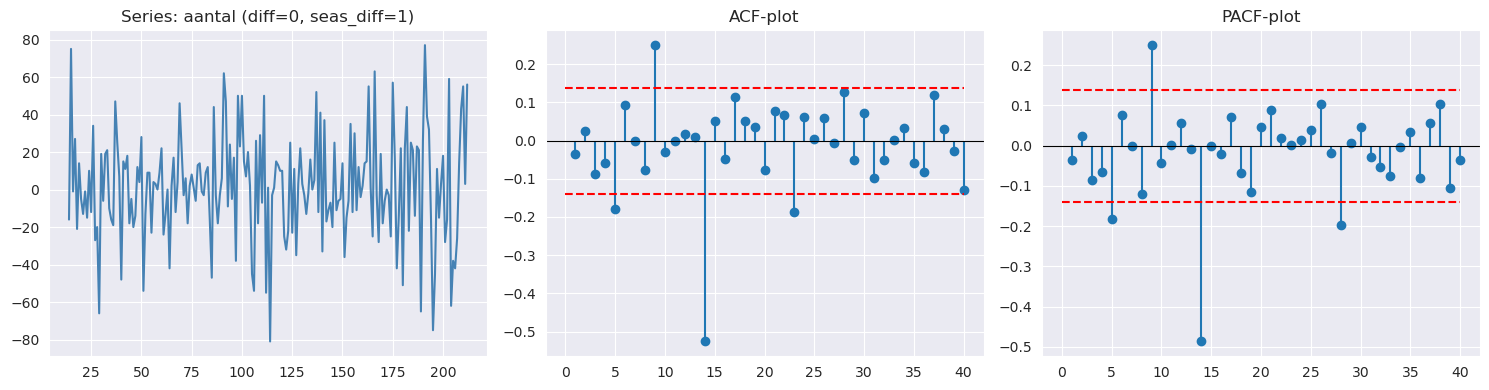

In [165]:
plot_series(aantallen, 'aantal', lags=40, diff=0, seasonal_diff=1, seasonal_period=14)

seasonality in ACF gevonden, door de tellen naar elk hoogste punt, er zit telkens 14 dagen? tussen, dus voor sarima is m = 14.

Hij is ook minder toenemend met seasonal differencing 1 dan zonder, dus hij is nu ook meer stationair.

in ACF oscillerende dempend, P = 1
in de pacf ziet yaika dempend oscillerend, dus Q=1

onze seasonal differencing was D=1

p = 1
q = 1
d= 0


/home/s24144738/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/s24144738/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


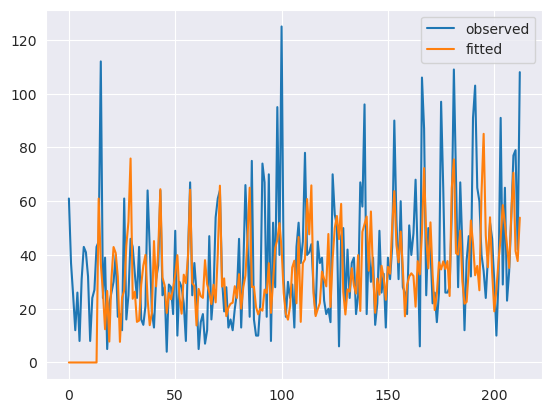

In [71]:
# fit SARIMA-model met (p,d,q)=(0,1,2), (P,D,Q)=(3,4,5) en m=12
model = ARIMA(aantallen["aantal"], order=(0,0,1), seasonal_order=(0,1,1,14))
fitted = model.fit()

y = aantallen["aantal"]
fv = fitted.fittedvalues

y_aligned, fv_aligned = y.align(fv, join="inner")

plt.plot(y_aligned.index, y_aligned, label="observed")
plt.plot(fv_aligned.index, fv_aligned, label="fitted")
plt.legend()
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                  -3.886393
p-value                          0.002137
#Lags Used                       8.000000
Number of Observations Used    204.000000
Critical Value (1%)             -3.462818
Critical Value (5%)             -2.875815
Critical Value (10%)            -2.574379
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.167049
p-value                  0.100000
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


/tmp/ipykernel_3300955/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


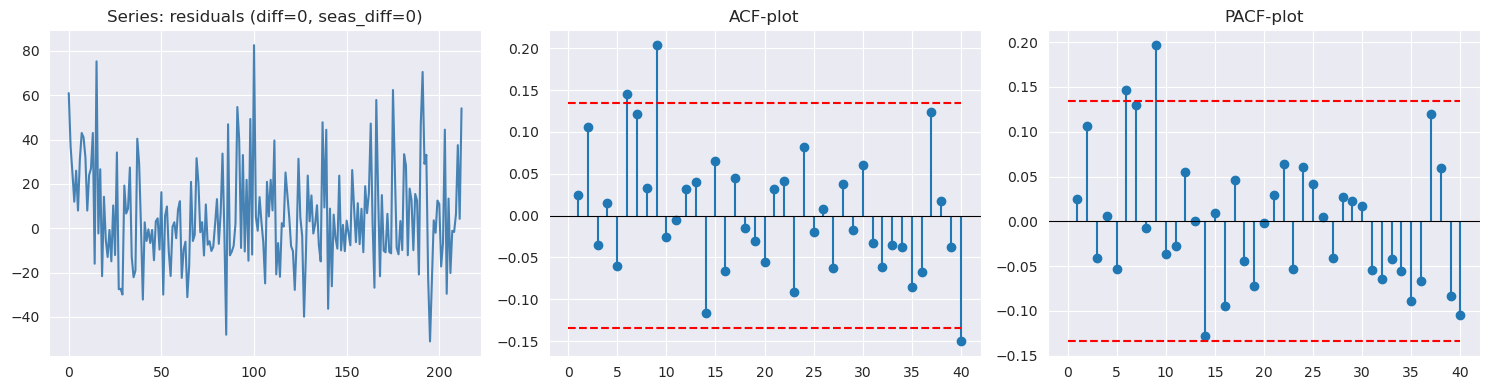

In [25]:
resid_df = pd.DataFrame({
    "residuals": fitted.resid
})

plot_series(
    resid_df,
    series_name="residuals",
    lags=40,
    diff=0,
    seasonal_diff=0,
    seasonal_period=14
)


In [27]:
from statsmodels.stats.weightstats import DescrStatsW
_, p, _ = DescrStatsW(fitted.resid).ttest_mean(0)
print(f"P-Value is {p:.3f}")

P-Value is 0.001


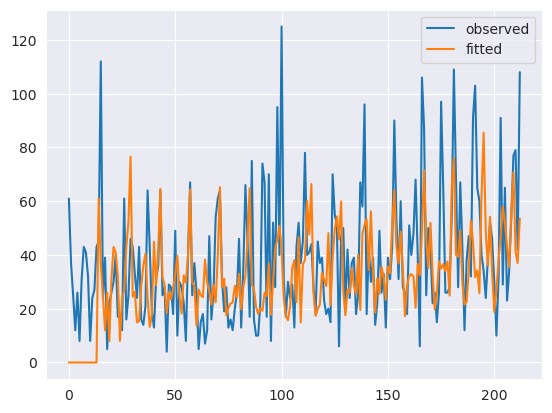

In [216]:
# fit SARIMA-model met (p,d,q)=(0,1,2), (P,D,Q)=(3,4,5) en m=12
model = ARIMA(aantallen["aantal"], order=(0,0,0), seasonal_order=(0,1,1,14))
fitted = model.fit()

y = aantallen["aantal"]
fv = fitted.fittedvalues

y_aligned, fv_aligned = y.align(fv, join="inner")

plt.plot(y_aligned.index, y_aligned, label="observed")
plt.plot(fv_aligned.index, fv_aligned, label="fitted")
plt.legend()
plt.show()


In [217]:
forecast_res = fitted.get_forecast(steps=30)

forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

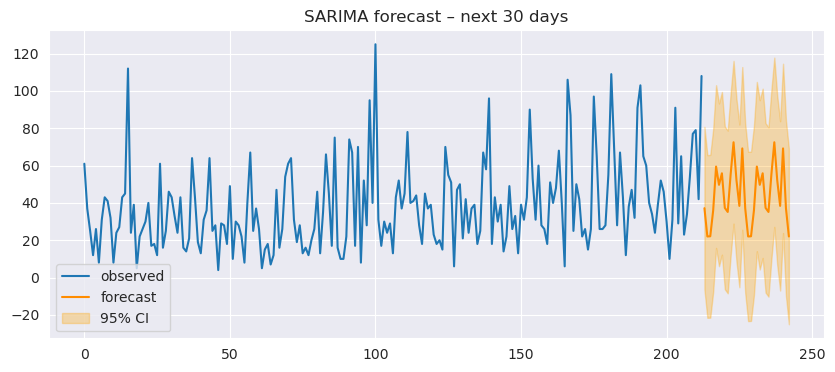

In [218]:
plt.figure(figsize=(10,4))

plt.plot(y.index, y, label="observed")
plt.plot(forecast_mean.index, forecast_mean, label="forecast", color="darkorange")

plt.fill_between(    forecast_ci.index,    forecast_ci.iloc[:, 0],    forecast_ci.iloc[:, 1],color="orange",    alpha=0.3,    label="95% CI")

plt.legend(loc='lower left')
plt.title("SARIMA forecast – next 30 days")
plt.show()


In [204]:
series = (df.groupby('start_date')
            .size()
            .asfreq('D', fill_value=0)
            .rename('aantal'))
y = np.log1p(series)


In [219]:
from pmdarima import auto_arima

model = auto_arima(
    y,                      # of series als je geen log gebruikt
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    start_P=0,
    start_Q=0,
    max_P=2,
    max_Q=2,
    d=None,
    D=1,
    seasonal=True,
    m=14,
    information_criterion="aic",
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    trace=True
)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[14] intercept   : AIC=1898.166, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[14] intercept   : AIC=1825.625, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[14] intercept   : AIC=1808.392, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[14]             : AIC=1896.736, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[14] intercept   : AIC=1899.924, Time=0.10 sec
 ARIMA(0,0,1)(1,1,1)[14] intercept   : AIC=1809.336, Time=0.40 sec
 ARIMA(0,0,1)(0,1,2)[14] intercept   : AIC=1809.682, Time=0.85 sec
 ARIMA(0,0,1)(1,1,0)[14] intercept   : AIC=1825.626, Time=0.23 sec
 ARIMA(0,0,1)(1,1,2)[14] intercept   : AIC=1809.057, Time=0.64 sec
 ARIMA(0,0,0)(0,1,1)[14] intercept   : AIC=1806.497, Time=0.14 sec
 ARIMA(0,0,0)(1,1,1)[14] intercept   : AIC=1807.425, Time=0.21 sec
 ARIMA(0,0,0)(0,1,2)[14] intercept   : AIC=1807.778, Time=0.55 sec
 ARIMA(0,0,0)(1,1,0)[14] intercept   : AIC=1823.717, Time=0.18 sec
 ARIMA(0,0,0)(1,1,2)[14] intercept   : AIC=1807.170, Time=0.57 sec
 ARIMA(1,0,0)(0,1,1

In [56]:
aantallen['aantal_boxcox'], fitted_lambda = scipy.stats.boxcox(aantallen['aantal'])
fitted_lambda

0.24609811707668786

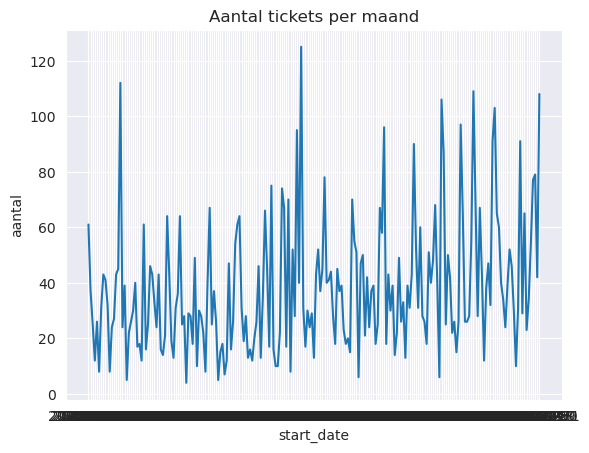

In [83]:
sns.lineplot(data=aantallen, x='start_date', y='aantal')
plt.title("Aantal tickets per maand")
plt.show()

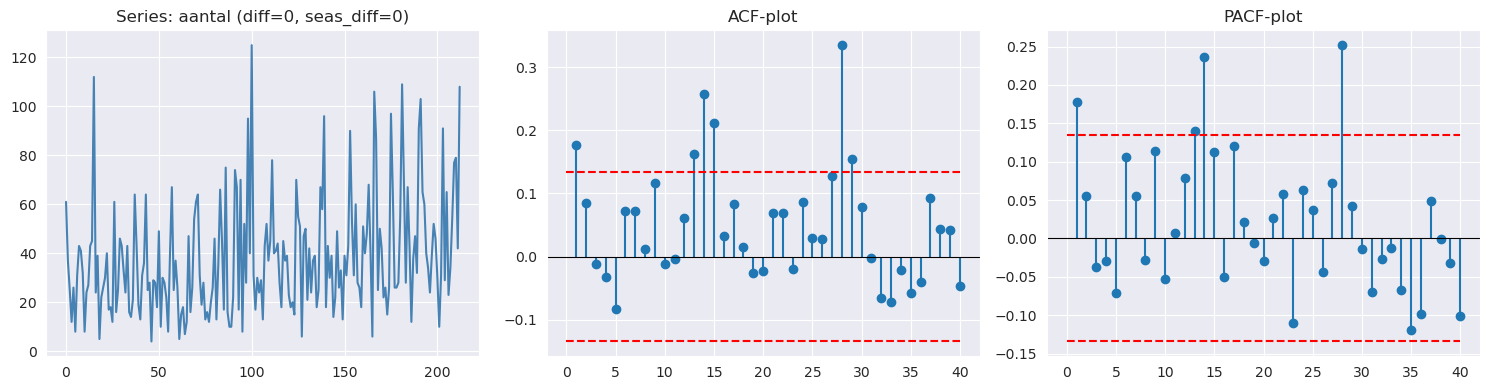

In [82]:
plot_series(aantallen, 'aantal', diff=0)

In [71]:
aantallen['aantal_boxcox_detrend'] = aantallen['aantal_boxcox'] - \
                                                     aantallen['aantal_boxcox'].shift(2)

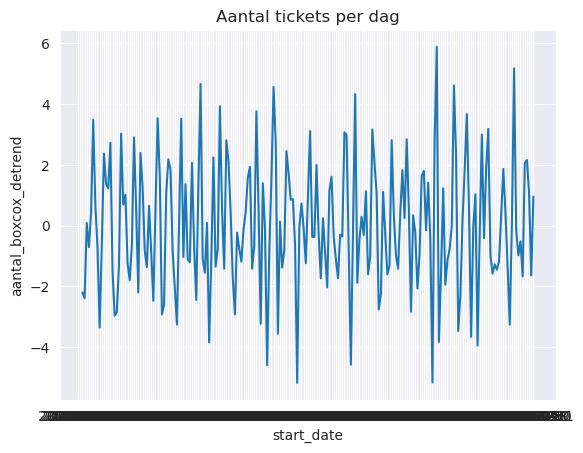

In [72]:
sns.lineplot(data=aantallen, x='start_date', y='aantal_boxcox_detrend')
plt.title("Aantal tickets per dag")
plt.show()

In [73]:
adf_test(aantallen['aantal_boxcox_detrend'].dropna())
kpss_test(aantallen['aantal_boxcox_detrend'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -7.425543e+00
p-value                        6.563614e-11
#Lags Used                     1.500000e+01
Number of Observations Used    1.950000e+02
Critical Value (1%)           -3.464337e+00
Critical Value (5%)           -2.876479e+00
Critical Value (10%)          -2.574733e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.210045
p-value                   0.100000
Lags Used                47.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/tmp/ipykernel_3004756/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


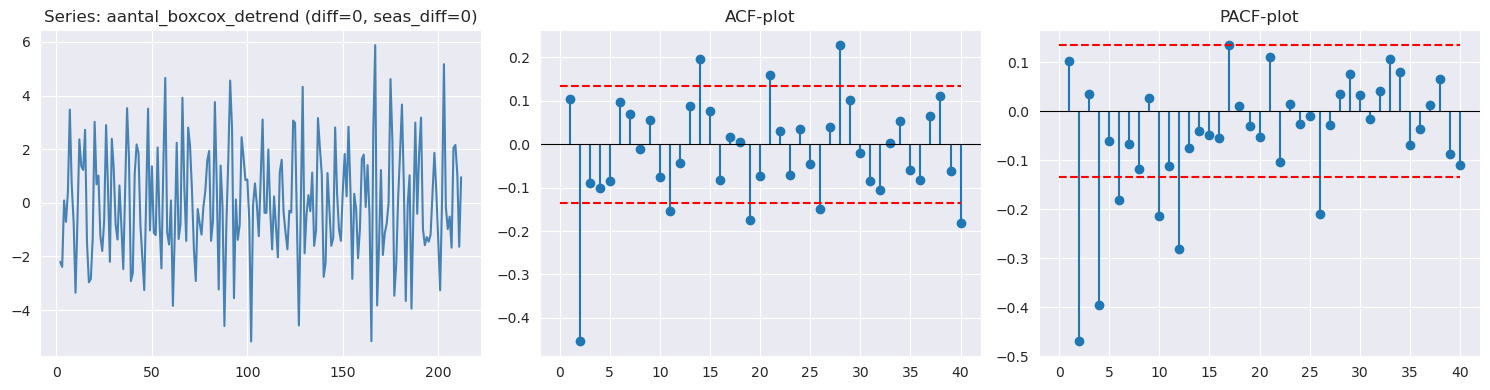

In [74]:
plot_series(aantallen, 'aantal_boxcox_detrend')